## Next Steps
* Only keep first 48 hours of labs
* Address that some patients may have more than 1 hospitalencounterID

* Define staging system for AKI 
* consider other variables to be included (oxygen saturation, diagnosis codes, procedures)
* clean up ethnicity groups even more
* Should make sure setting index always to hospiralenouncter id instead of patient encounter Id for consistency 
* Validation of specific hospitalencoutnerids (temp, BMI)
* Cross validation for number of variables to include in stepwise regression 

## Current Questions to clarify 
* Review how AKI was defined in code, used two different criteria based on serum creatinine
* Review adding white blood cell count 
* Have approximately 4,000 confirmed cases to be included (make sure way it was defined is okay)
* 89 admitted to ICU (make sure how ICU was defined okay)
* Some hospitalencounterIds have multiple ethnicities listed in QAQI (for now just keeping first that appears)
* Currently using avg lab values over course of hospitalencounterId to define albuminum,chloride etc. variables 

## Other Variables still to consider 
* Use of Mechanical Ventilation
* Other lab values 


# Importing Libraries 

In [1]:
# Load needed libraries
import pandas as pd
pd.set_option('display.max_columns', 60)

# import pypyodbc as podbc  # access to database
import aioodbc as podbc # access to parallel database
import asyncio  # allow parallel execution

import numpy as np
from numpy import nan

import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
working_path = os.getcwd() 

## Setting Up Needed Variables 

In [3]:
# Import / reload data from db
import_from_db = True
export_data=False

## Import Data from QAQI 

In [4]:
# Generic function to run SQL
async def runSql(query):
	sql_conn = await podbc.connect(dsn=dsn, loop=loop)

	cur = await sql_conn.cursor()
	await cur.execute(query)
	results = await cur.fetchall()

	results = pd.DataFrame((tuple(t) for t in results))
	results.columns = [column[0] for column in cur.description]

	await sql_conn.close()
	return results

In [5]:
# Retrieve patient demographics
def get_demographics(patientids):
	return 'SELECT * FROM Dev.viewDemographics vd WHERE vd.patientID IN (%s)' % patientids

In [6]:
# Retrieve patient problem list
def get_problemlist(patientids):
	return 'SELECT * FROM Dev.viewProblemList vpl WHERE vpl.patientID IN (%s)' % patientids

In [7]:
# Retrieve patient medical history
def get_medicalhistory(patientids):
	return 'SELECT * FROM Dev.viewMedicalHistory vmh WHERE vmh.patientID IN (%s)' % patientids

In [8]:
# Retrieve hospital medications
# TODO: get meds only in the categories we want
def get_hospitalmeds(hospitalencounterids):
	return 'SELECT * FROM Dev.viewHospitalMeds vmh WHERE vmh.hospitalencounterid IN (%s)' % hospitalencounterids

In [9]:
# Retrieve home medications
# TODO: get meds only in the categories we want
def get_homemeds(hospitalencounterids, patientids):
	return 'SELECT * FROM Dev.viewHomeMeds vmh WHERE vmh.hospitalencounterid IN ({0}) and vmh.patientID IN ({1})'.format(hospitalencounterids, patientids)

In [10]:
# Retrieve Patient Infection
def get_patientInfection(patientids):
	return 'SELECT * FROM Prod.EDW_Patient_Infection_BWH pi WHERE pi.PatientID IN (%s)' % patientids

In [11]:
# Retrieve Patient Ethnic Background 
def get_patientEthnicBackground(patientids):
	return 'SELECT * FROM prod.EDW_Patient_EthnicBackground_BWH eb WHERE eb.PatientID IN (%s)' % patientids

In [13]:
''''
Data on AKI, labs, ICU addmisssion, Comorbidities and vitals were pulled directly in Azure data studio using hospitalencounterids. SQL code is in code/SQl folder 
'''


In [14]:
# Connect to the research database server  # Change connection to QAQI 
if import_from_db == True:
    dsn = 'driver=/usr/local/lib/libmsodbcsql.17.dylib; server=PHSSQL2023.PARTNERS.ORG;database=bwhanesqaqi;trusted_connection=yes'
    loop = asyncio.get_event_loop()
    sql_conn = await podbc.connect(dsn=dsn, loop=loop)

In [16]:
'''
Get case ids for those matching inclusion criteria
Read SQL from file and execute against server
'''
if import_from_db == True:
    with open(working_path + '/sql/thesis_caseids.sql','r') as file:
        query = file.read()

In [17]:
if import_from_db == True:
    cur = await sql_conn.cursor()
    await cur.execute(query)
    caseids = await cur.fetchall()
    await sql_conn.close()

In [18]:
if import_from_db == True:  
    caseids = pd.DataFrame((tuple(t) for t in caseids))
    caseids.columns = [column[0] for column in cur.description]

    #caselogids = str(caseids.caseLogID.astype(int).tolist()).strip('[]')
    patientids = str(caseids.patientID.tolist()).strip('[]')
    hospitalencounterids = str(caseids.hospitalEncounterID.astype(int).tolist()).strip('[]')

In [19]:
# Get data from database in parallel
# Does not take very long
if import_from_db == True:
    results = await asyncio.gather(
            # runSql(get_caseinfo(caselogids)),
            # runSql(get_casetimes(caselogids)),
            runSql(get_demographics(patientids)),
           # runSql(get_vitals(caselogids)),
             runSql(get_problemlist(patientids)),
            #runSql(get_medicalhistory(patientids)),
            #runSql(get_hospitalmeds(hospitalencounterids)),
            #runSql(get_homemeds(hospitalencounterids, patientids)),
            runSql(get_patientEthnicBackground(patientids)),
            runSql(get_patientInfection(patientids))
           # runSql(get_labs(hospitalencounterids, patientids))
        )
    # Split the result data list into separate variables
demographics,problemlist,ethnicBackground, infection= results
#demographics,  problemlist, medicalhistory, hospitalmeds, homemeds, ethnicBackground, infection,labs = results

## Importing data from CSV 


In [51]:
# information was pulled directly in SQL using hospitalencounterids specified from caseids script
vitals=pd.read_csv(working_path.replace('/code','') + '/data/vitals_results.csv')
# labs=pd.read_csv(working_path.replace('/code','') + '/data/labs_results.csv') # added more labs and made sars its own data
adt=pd.read_csv(working_path.replace('/code','') + '/data/adt_results.csv')
AKI=pd.read_csv(working_path.replace('/code','') + '/data/aki_results.csv')
comorbs=pd.read_csv(working_path.replace('/code','') + '/data/comorb_results.csv')

In [133]:
#labs=pd.read_csv(working_path.replace('/code','') + '/data/labs_results.csv')

In [185]:
labs=pd.read_csv(working_path.replace('/code','') + '/data/labs_results1.csv')

In [54]:
sars=pd.read_csv(working_path.replace('/code','') + '/data/sars_results.csv')

# Cleaning Dataframes 

In [55]:
caseids.nunique()
caseids.head()

# converting admitDTS to datetime
caseids['admitDTS']=caseids['admitDTS'].map(pd.to_datetime)
min(caseids.admitDTS),max(caseids.admitDTS)

(Timestamp('2020-01-06 14:57:00'), Timestamp('2020-09-30 11:13:00'))

## Demographics 

In [56]:
'''
Cleaning Demographics Data frame. Adding 'Sex' column where 1 is male, 0 is female. Calculating age as difference between dob and admitDTS (when admitted into hospital)
'''
demographics['sex'] = np.where(demographics['gender']=='Male',1,0)
demographics['dob']=demographics['dob'].map(pd.to_datetime)
demographics2=demographics[['patientID','dob','gender','sex']] 
demographics3=pd.merge(caseids, demographics2, on=['patientID'], how='outer')
demographics3=demographics3.drop_duplicates() 
demographics3['age']=demographics3['admitDTS'] - demographics3['dob']
demographics3['age']=demographics3['age']/np.timedelta64(1,'Y')

demographics3=demographics3.dropna(subset=['admitDTS'])   # only patients that were admitted 
demographics_final=demographics3[['hospitalEncounterID','sex','age']]
demographics_final=demographics_final.set_index('hospitalEncounterID')
demographics_final.nunique()

sex        2
age    16884
dtype: int64

## Vitals 
keep only first 48 hours vitals  (using contactDTS, this is essentially same as admitDTS for caseids)

In [57]:
vitals=vitals.drop(['PatientID', 'PatientEncounterDateRealNBR','ContactDTS'], axis=1)
vitals_final=vitals.set_index('PatientEncounterID')

In [43]:
#vitals[vitals.duplicated(['PatientEncounterID'])]
#final_df[final_df.duplicated(['PatientID'])]
# temp less than 80   
#vitals_final.dropna(subset=['TemperatureFahrenheitNBR'])
#vitals_final[vitals_final['TemperatureFahrenheitNBR']<50]


## Ethnic Background 

In [58]:
## What about Indian ??  'Asian Indian', 'Caribbean Island-West Indian', 'Central American-Indian'

ethnicBackground1=pd.merge(caseids, ethnicBackground[['PatientID','EthnicityDSC']], left_on=['patientID'],right_on=['PatientID'], how='outer')[['PatientID','hospitalEncounterID','EthnicityDSC']].drop_duplicates()

## Black or African
ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['EthnicityDSC'].str.contains('African',regex=False),'Black or African',ethnicBackground1['EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['EthnicityDSC'].str.contains('Haitian',regex=False),'Black or African',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['EthnicityDSC'].str.contains('Cape Verdean',regex=False),'Black or African',ethnicBackground1['New_EthnicityDSC'])

## White (non-hispanic)
ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('European',regex=False),'White (non-hispanic)',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Middle Eastern',regex=False),'White (non-hispanic)',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Portuguese',regex=False),'White (non-hispanic)',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Russian',regex=False),'White (non-hispanic)',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC']=='American','White (non-hispanic)',ethnicBackground1['New_EthnicityDSC'])

## Hispanic or Latino
ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Mexican',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Central American',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Caribbean',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('South American',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Puerto Rican',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Dominican',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Salvadoran',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Brazilian',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Colombian',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Honduran',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Honduran',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])
ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Guatemalan',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Cuban',regex=False),'Hispanic Or Latino',ethnicBackground1['New_EthnicityDSC'])

## Asian (Non Hispanic)
ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Asian',regex=False),'Asian (Non Hispanic)',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Chinese',regex=False),'Asian (Non Hispanic)',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Japanese',regex=False),'Asian (Non Hispanic)',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Vietnamese',regex=False),'Asian (Non Hispanic)',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Korean',regex=False),'Asian (Non Hispanic)',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Filipino',regex=False),'Asian (Non Hispanic)',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Cambodian',regex=False),'Asian (Non Hispanic)',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Laotian',regex=False),'Asian (Non Hispanic)',ethnicBackground1['New_EthnicityDSC'])

## Other 
ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Declined',regex=False),'Other',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Unavailable',regex=False),'Other',ethnicBackground1['New_EthnicityDSC'])

ethnicBackground1['New_EthnicityDSC']=pd.np.where(ethnicBackground1['New_EthnicityDSC'].str.contains('Other-Specify',regex=False),'Other',ethnicBackground1['New_EthnicityDSC'])

# some patients have two listed ethnicities for a hospital encounterID 
ethnicBackground1[ethnicBackground1['hospitalEncounterID']==3303232633]


,PatientID,hospitalEncounterID,EthnicityDSC,New_EthnicityDSC
158,Z17584081,3303232633,South American,Hispanic Or Latino
159,Z17584081,3303232633,American,White (non-hispanic)


In [59]:
'''
There are 18345 rows, but there should only be 16994 (number of unique hospitalencounterids). Some hospitalencounterIDs have two ethnicities listed
'''
## look at these hospitalencounterIds , problem with white and other 
# 3302530375
# 3301122293
# 3304269389

# For now just keeping last 
ethnicBackground2=ethnicBackground1.drop_duplicates(subset='hospitalEncounterID', keep="last")[['hospitalEncounterID','New_EthnicityDSC']]
ethnic_background_final=ethnicBackground2.set_index('hospitalEncounterID')


In [60]:
'Creating 0,1 variables for ethnicity groups'

ethnic_background_final['Black or African']=np.where(ethnic_background_final['New_EthnicityDSC']=='Black or African',1,0)
ethnic_background_final['White (non-hispanic)']=np.where(ethnic_background_final['New_EthnicityDSC']=='White (non-hispanic)',1,0)
ethnic_background_final['Asian (Non Hispanic)']=np.where(ethnic_background_final['New_EthnicityDSC']=='Asian (Non Hispanic)',1,0)
ethnic_background_final['Hispanic Or Latino']=np.where(ethnic_background_final['New_EthnicityDSC']=='Hispanic Or Latino',1,0)
ethnic_background_final['Other_Ethnicity']=np.where(ethnic_background_final['New_EthnicityDSC']=='Other',1,0)

## Confirmed COVID-19 Cases 

In [186]:
'''Defining Postive COVID-19 Cases based on lab Results, including presumed cases as positive'''

## Use sars PCR as indicator for COVID-19
# SARS Confirmed Cases 
sars_data=sars

## Postive COVID-19 cases are defined using the ResultTXT variable taking on the following values 
sars_data['TestPositive']=pd.np.where(sars_data['resultTXT']=='Detected',1,0)
sars_data['TestPositive']=pd.np.where(sars_data['resultTXT']=='SARS-CoV-2 detected',1, sars_data['TestPositive'])
sars_data['TestPositive']=pd.np.where(sars_data['resultTXT']=='Positive for 2019-novel Coronavirus (2019-nCoV) by PCR.',1, sars_data['TestPositive'])
sars_data['TestPositive']=pd.np.where(sars_data['resultTXT']=='Positive for SARS-Cov-2 (COVID-19) by PCR',1, sars_data['TestPositive'])
sars_data['TestPositive']=pd.np.where(sars_data['resultTXT']=='Positive',1, sars_data['TestPositive'])
sars_data['TestPositive']=pd.np.where(sars_data['resultTXT']=='Presumptive positive for 2019-novel Coronavirus (2019-nCoV) by PCR.',1, sars_data['TestPositive'])
sars_data['TestPositive']=pd.np.where(sars_data['resultTXT']=='Presumptive Positive',1, sars_data['TestPositive'])
sars_data['TestPositive']=pd.np.where(sars_data['resultTXT']=='Presumptive positive for SARS-Cov-2 (COVID-19) by PCR',1, sars_data['TestPositive'])

## Subsetting Sars Data 
sars_data1=sars_data[['PatientID','PatientEncounterID','BaseNM','resultTXT','TestPositive']].drop_duplicates()
print("Positive COVID-19 Cases:",sars_data1['TestPositive'].sum())

Positive COVID-19 Cases: 4225


In [187]:
# Only keeping positive Cases 
sars_data2=sars_data1[sars_data1['TestPositive']==1]
sars_data2=sars_data2.set_index('PatientEncounterID')

## Lab Values 

Labs considered include: WBC,HCO3,K,GLU,CA,CL,ALB,CRPT,LDH


Including lab values from first 48 hours after admission


In [188]:
# filtering labs to make sure it is less than 99999
labs2=labs[labs['ResultValueNBR']<9999999]  # this also removes Sars 

In [189]:
labs2.BaseNM.unique()

array(['K', 'GLU', 'CL', 'CA', 'ALB', 'WBC', 'HC03', 'LDH', 'CRPT'],
      dtype=object)

In [190]:
labs2['OrderDTS']=labs2['OrderDTS'].map(pd.to_datetime) # takes about 5 mins

In [191]:
from datetime import datetime, timedelta

'''
Defining function to keep only records from the time a patient's admitDTS and 48 hours their admitDTS. Using these records to keep only lab values for patients from the first 48 hours after their admission. 
'''

def isRecordedDTSBetweenStartEndTime1(row):
    hospID = row.PatientEncounterID
    #caseLogID = caseids[caseids['hospitalEncounterID']==hospID]['caseLogID'].iloc[0]
    starttime=caseids[caseids['hospitalEncounterID']==hospID]['admitDTS'].iloc[0]
    endtime= starttime + timedelta(hours=48 )  # endtime is 48 hours after admission 
    #starttime = casetimes[casetimes['LogID']==caseLogID]['Out of Room'].iloc[0]
    #endtime = starttime + timedelta(hours=24)
    return ((row['OrderDTS']>=starttime) & (row['OrderDTS']<=endtime))

In [192]:
labs_startendtimes = labs2[labs2.apply(lambda x: isRecordedDTSBetweenStartEndTime1(x), axis=1)]

In [193]:
'''Potassium'''  ## all are the same unit mmol/L (or na)
PotassiumData=labs_startendtimes[labs_startendtimes['BaseNM']=='K'][['PatientID','PatientEncounterID','ResultValueNBR']]
PotassiumData=PotassiumData.rename(columns={"ResultValueNBR":"PotassiumResult"})      
PotassiumAvg=PotassiumData.groupby('PatientEncounterID').mean()   

In [194]:
'''Calcium''' 
CalciumData=labs_startendtimes[labs_startendtimes['BaseNM']=='CA'][['PatientID','PatientEncounterID','ResultValueNBR']]
CalciumData=CalciumData.rename(columns={"ResultValueNBR":"CalciumResult"})
CalciumAvg=CalciumData.groupby('PatientEncounterID').mean()

In [195]:
'''Chloride'''
ChlorideData=labs_startendtimes[labs_startendtimes['BaseNM']=='CL'][['PatientID','PatientEncounterID','ResultValueNBR']]
ChlorideData=ChlorideData.rename(columns={"ResultValueNBR":"ChlorideResult"})
ChlorideAvg=ChlorideData.groupby('PatientEncounterID').mean()

In [196]:
'''Bicarbonate'''
BicarbonateData=labs_startendtimes[labs_startendtimes['BaseNM']=='HC03'][['PatientID','PatientEncounterID','ResultValueNBR']]
BicarbonateData=BicarbonateData.rename(columns={"ResultValueNBR":"BicarbonateResult"})
BicarbonateAvg=BicarbonateData.groupby('PatientEncounterID').mean()

In [197]:
'''Albumin'''
AlbuminData=labs_startendtimes[labs_startendtimes['BaseNM']=='ALB'][['PatientID','PatientEncounterID','ResultValueNBR']]
AlbuminData=AlbuminData.rename(columns={"ResultValueNBR":"AlbuminResult"})
AlbuminAvg=AlbuminData.groupby('PatientEncounterID').mean()

In [198]:
'''White Blood Cell Count'''
WBC_Data=labs_startendtimes[labs_startendtimes['BaseNM']=='WBC'][['PatientID','PatientEncounterID','ResultValueNBR']]
WBC_Data=WBC_Data.rename(columns={"ResultValueNBR":"WhiteBloodCellCNT"})
WBC_Avg=WBC_Data.groupby('PatientEncounterID').mean()

In [199]:
'''Glucose'''
GLU_Data=labs_startendtimes[labs_startendtimes['BaseNM']=='GLU'][['PatientID','PatientEncounterID','ResultValueNBR']]
GLU_Data=GLU_Data.rename(columns={"ResultValueNBR":"Glucose"})
GLU_Avg=GLU_Data.groupby('PatientEncounterID').mean()

In [200]:
'''CRPT'''
CRPT_Data=labs_startendtimes[labs_startendtimes['BaseNM']=='CRPT'][['PatientID','PatientEncounterID','ResultValueNBR']]
CRPT_Data=CRPT_Data.rename(columns={"ResultValueNBR":"CRPT"})
CRPT_Avg=CRPT_Data.groupby('PatientEncounterID').mean()

In [201]:
'''LDH'''
LDH_Data=labs_startendtimes[labs_startendtimes['BaseNM']=='LDH'][['PatientID','PatientEncounterID','ResultValueNBR']]
LDH_Data=LDH_Data.rename(columns={"ResultValueNBR":"LDH"})
LDH_Avg=LDH_Data.groupby('PatientEncounterID').mean()

In [202]:
# Merging All Lab Values together by patient EncounterID 
labs_final=pd.merge(sars_data2,PotassiumAvg,how='left',left_index=True,right_index=True)
labs_final=pd.merge(labs_final,CalciumAvg,how='left',left_index=True,right_index=True)
labs_final=pd.merge(labs_final,ChlorideAvg,how='left',left_index=True,right_index=True)
labs_final=pd.merge(labs_final,BicarbonateAvg,how='left',left_index=True,right_index=True)
labs_final=pd.merge(labs_final,AlbuminAvg,how='left',left_index=True,right_index=True)
labs_final=pd.merge(labs_final,WBC_Avg,how='left',left_index=True,right_index=True)
labs_final=labs_final.rename(columns={"PotassiumResult":"PotassiumResultAvg","CalciumResult":"CalciumResultAvg","ChlorideResult":"ChlorideResultAvg","BicarbonateResult":"BicarbonateResultAvg","AlbuminResult":"AlbuminResultAvg"})

In [203]:
labs_final

,PatientID,BaseNM,resultTXT,TestPositive,PotassiumResultAvg,CalciumResultAvg,ChlorideResultAvg,BicarbonateResultAvg,AlbuminResultAvg,WhiteBloodCellCNT
PatientEncounterID,,,,,,,,,,
3289168479,Z11087962,SARSCOV2,SARS-CoV-2 detected,1,4.528571,6.885714,99.857143,NaN,2.757143,10.492500
3289171959,Z15775199,SARSCOV2,Positive,1,NaN,NaN,NaN,NaN,NaN,18.780000
3291672575,Z10310973,SARSCOV2,SARS-CoV-2 detected,1,4.250000,8.300000,103.000000,NaN,3.200000,14.145000
3291773313,Z9553856,SARSCOV2,SARS-CoV-2 detected,1,3.640000,8.160000,100.600000,NaN,2.925000,11.014286
3295482760,Z13728835,SARSCOV2,SARS-CoV-2 detected,1,3.800000,8.000000,102.000000,NaN,3.000000,18.736667
...,...,...,...,...,...,...,...,...,...,...
3313243792,Z7661859,SARSCOV2,Positive for 2019-novel Coronavirus (2019-nCoV...,1,NaN,NaN,NaN,NaN,NaN,NaN
3313282005,Z17795276,SARSCOV2,Positive for 2019-novel Coronavirus (2019-nCoV...,1,NaN,NaN,NaN,NaN,NaN,NaN
3313438563,Z15385057,SARSCOV2,Detected,1,NaN,NaN,NaN,NaN,NaN,NaN


## Acute Kidney Injury 

AKI will be defined using the following criteria from KDIGO: 
-	Increase in serum creatinine by .3mg/dL or more within 48 hours or
-	Increase in serum creatinine by 1.5 times baseline or more within last 7 days or 

The staging system for AKI severity to potentially be considered from KDIGO is: 
-   Stage 1: Serum Creatinine 1.5-1.9 times baseline or >.3mg/dL increase, and urine output<.5mL/kg/h for 6 h 
-   Stage 2: Serum Creatinine 2-2.9 times baseline or Urine output <.5mL/kg/h for 12 h 
-   Stage 3: Serum Creatinine 3 times baseline or increase >4mg/dL or initiation of renal replacement therapy or


In [116]:
# mapping to datetime 
AKI['ResultDTS']=AKI['ResultDTS'].map(pd.to_datetime)

In [117]:
'''
Defining AKI based on Increase in serum creatinine by .3mg/dL or more within 48 hours (takes some time to run)
'''  

from datetime import datetime, timedelta
 
disease_status=[]  # keeping track of AKI occurence for each hospitalencounterID 

for ID in AKI['PatientEncounterID'].drop_duplicates():
    hospID=AKI[AKI['PatientEncounterID']==ID]
    hospID=hospID.sort_values(by=['ResultDTS']).drop_duplicates().reset_index(drop=True)
    
    for i in range (0,len(hospID)): 
        AKI_occurence=[]  # keeping track of AKI occurence within 48 hour intervals 
        start_date=hospID['ResultDTS'][i]
        end_date= start_date+ timedelta(hours=48)  # adding 48 hours to starttime 
        start_end=hospID[(hospID['ResultDTS']>= start_date) & (hospID['ResultDTS']<=end_date)]
        difference=max(start_end['ResultValueNBR'])-min(start_end['ResultValueNBR'])

        if (difference>=.3):
            AKI_occurence.append(1) 
            break 
        else:
            AKI_occurence.append(0)
    disease_status.append(max(AKI_occurence))

aki_crit1 = pd.DataFrame()
aki_crit1['hospitalEncounterID']  = AKI['PatientEncounterID'].drop_duplicates()
aki_crit1['aki_crit1']  = disease_status

In [118]:
aki_crit1=aki_crit1.set_index('hospitalEncounterID')
print('Prop of AKI occurence:',sum(aki_crit1['aki_crit1'])/len(aki_crit1))

Prop of AKI occurence: 0.19249635423571523


In [119]:

'''
Defining AKI using Increase in serum creatinine by 1.5 times baseline or more within last 7 days

Baseline Creatinine :
For patients without a baseline creatinine in the 7 to 365 days prior to admission, the admission creatinine was imputed based upon a Modification of Diet in Renal Disease (MDRD) estimated glomerular filtration fraction (eGFR) of 75 ml/min/1.73m as per the Kidney Disease: Improving Global Outcomes (KDIGO) AKI guidelines
-- from Acute Kidney Injury in Hospitalized COVId-19 patients resource
-- https://kdigo.org/wp-content/uploads/2016/10/KDIGO-2012-AKI-Guideline-English.pdf pg 29 estimating baseline creatinine
'''

## Estimated Baseline Creatinine , based on ethnic background, gender, and age 
baseline=pd.merge(demographics_final,ethnic_background_final,how='left',left_index=True,right_index=True)
baseline['baseline_SCr']=[None]*len(baseline)   # initiate new column 

# other males 
baseline['baseline_SCr']=np.where((baseline['sex']==1) & (baseline['age']>=20)  & (baseline['age']<=24) & 
(baseline['New_EthnicityDSC']!='Black or African'), 1.3, baseline['baseline_SCr'])

baseline['baseline_SCr']=np.where((baseline['sex']==1) & (baseline['age']>=25)  & (baseline['age']<=39) & 
(baseline['New_EthnicityDSC']!='Black or African'), 1.2, baseline['baseline_SCr'])

baseline['baseline_SCr']=np.where((baseline['sex']==1) & (baseline['age']>=40)  & (baseline['age']<=65) & 
(baseline['New_EthnicityDSC']!='Black or African'), 1.1, baseline['baseline_SCr'])

baseline['baseline_SCr']=np.where((baseline['sex']==1) & (baseline['age']>65) & 
(baseline['New_EthnicityDSC']!='Black or African'), 1.0, baseline['baseline_SCr'])

# Black males 
baseline['baseline_SCr']=np.where((baseline['sex']==1) & (baseline['age']>=20)  & (baseline['age']<=29) & 
(baseline['New_EthnicityDSC']=='Black or African'), 1.5, baseline['baseline_SCr'])

baseline['baseline_SCr']=np.where((baseline['sex']==1) & (baseline['age']>=30)  & (baseline['age']<=39) & 
(baseline['New_EthnicityDSC']=='Black or African'), 1.4, baseline['baseline_SCr'])

baseline['baseline_SCr']=np.where((baseline['sex']==1) & (baseline['age']>=40)  & (baseline['age']<=65) & 
(baseline['New_EthnicityDSC']=='Black or African'), 1.3, baseline['baseline_SCr'])

baseline['baseline_SCr']=np.where((baseline['sex']==1) & (baseline['age']>65) & 
(baseline['New_EthnicityDSC']=='Black or African'), 1.2, baseline['baseline_SCr'])

# other females  
baseline['baseline_SCr']=np.where((baseline['sex']==0) & (baseline['age']>=20)  & (baseline['age']<=29) & 
(baseline['New_EthnicityDSC']!='Black or African'), 1.0, baseline['baseline_SCr'])

baseline['baseline_SCr']=np.where((baseline['sex']==0) & (baseline['age']>=30)  & (baseline['age']<=54) & 
(baseline['New_EthnicityDSC']!='Black or African'), .9, baseline['baseline_SCr'])

baseline['baseline_SCr']=np.where((baseline['sex']==0) & (baseline['age']>=55) & 
(baseline['New_EthnicityDSC']!='Black or African'), .8, baseline['baseline_SCr'])

# black females  
baseline['baseline_SCr']=np.where((baseline['sex']==0) & (baseline['age']>=20)  & (baseline['age']<=24) & 
(baseline['New_EthnicityDSC']=='Black or African'), 1.2, baseline['baseline_SCr'])

baseline['baseline_SCr']=np.where((baseline['sex']==0) & (baseline['age']>=25)  & (baseline['age']<=39) & 
(baseline['New_EthnicityDSC']=='Black or African'), 1.1, baseline['baseline_SCr'])

baseline['baseline_SCr']=np.where((baseline['sex']==0) & (baseline['age']>=40) & (baseline['age']<=65) &
(baseline['New_EthnicityDSC']=='Black or African'), 1.0, baseline['baseline_SCr'])

baseline['baseline_SCr']=np.where((baseline['sex']==0) & (baseline['age']>=65) &
(baseline['New_EthnicityDSC']=='Black or African'), .9, baseline['baseline_SCr'])


In [120]:
AKI=AKI.rename(columns={"PatientEncounterID": "hospitalEncounterID"}).set_index('hospitalEncounterID')

In [121]:
aki_crit2=pd.merge(AKI,baseline['baseline_SCr'],how='left',left_index=True,right_index=True)
aki_crit2['Baseline_Comparison']=aki_crit2['ResultValueNBR']/aki_crit2['baseline_SCr']
aki_crit2['aki_crit2']=np.where(aki_crit2['Baseline_Comparison']>=1.5,1,0)
aki_crit2=aki_crit2.groupby(["hospitalEncounterID"])['aki_crit2'].max()

In [122]:
'''Merging together two AKI criteria tables and defining AKI outcome variable'''
aki_final=pd.merge(aki_crit1,aki_crit2,how='left',left_index=True,right_index=True)
aki_final['AKI_status']=np.where( (aki_final['aki_crit1']==1) | (aki_final['aki_crit1']==1),1,0 )
sum(aki_final['AKI_status'])/len(aki_final)

0.19249635423571523

## ICU Admission 

Only keep patients that have 1 hospitalenounterID 
see id patientdID have mroe than 1 hospitalenounterID and look at the corresponding date 

In [123]:
'''Data returned has multiple events on each patientencounterID, a row for each time transfered in/out of room'''
icu=adt[adt['ADTEventSubtypeDSC']!='Canceled']
# ICU[ICU['PatientEncounterID']==3304551434][['ADTEventTypeDSC','ADTEventSubtypeDSC','PatientEncounterID','RoomID','EffectiveDTS']].sort_values(by=['EffectiveDTS'])

In [124]:
# Patients that were admitted to the ICU  
icu_patients=icu.PatientEncounterID.unique()
# Add column of 1's for ICU admission, and left join this with final DF, all NAs turn to 0 meaning these patients were not addmitted 
icu_patients=caseids[caseids['hospitalEncounterID'].isin(icu_patients)].drop_duplicates().set_index('hospitalEncounterID')

# making ICU variable 
icu_patients['ICU']=['1']*len(icu_patients)
icu_patients['ICU']=icu_patients['ICU'].astype(int)

# Comorbidities 

Comorbs data contins patientIDs that have specific conditions (as defined by ICD-10 codes). Included all patiedIDs from caseids when quering for comorb conditions. 

In [125]:
comorbs['Hypertension']=np.where(comorbs['CurrentICD10ListTXT']=='I10',1,0)
comorbs['CKD']=np.where(comorbs['CurrentICD10ListTXT']=='N18.9',1,0)
comorbs['CongestiveFailure']=np.where(comorbs['CurrentICD10ListTXT']=='I50.9',1,0)  #ICD corresponds to unspecified heart failure but further filtered on diagnosis NM in SQL
comorbs['DiabetesMellitus']=np.where(comorbs['CurrentICD10ListTXT']=='E11',1,0)
comorbs['LiverDisease']=np.where(comorbs['CurrentICD10ListTXT']=='K76.9',1,0)
comorbs['PeripheralVascularDisease']=np.where(comorbs['CurrentICD10ListTXT']=='I73.9',1,0)

comorbs_final=comorbs[['patientID','Hypertension','CKD','CongestiveFailure','DiabetesMellitus','LiverDisease','PeripheralVascularDisease']]

comorbs_final=comorbs_final.groupby(['patientID'], sort=False)[['Hypertension','CKD','DiabetesMellitus','LiverDisease','PeripheralVascularDisease']].max()

## Merging Data frames 

In [151]:
# contains all positive COVID-19 patients # will obviously remove PatientID, testPostive, resultTXT and BaseNM when building models 
final_df=pd.merge(labs_final,demographics_final,how='left',left_index=True,right_index=True) 
final_df=pd.merge(final_df,vitals_final.drop(columns=['WeightPoundNBR', 'HeightTXT']),how='left',left_index=True,right_index=True) 
final_df=pd.merge(final_df,ethnic_background_final.drop(columns=['New_EthnicityDSC']),how='left',left_index=True,right_index=True) 
final_df=pd.merge(final_df,icu_patients['ICU'],how='left',left_index=True,right_index=True)
final_df=pd.merge(final_df,aki_final['AKI_status'],how='left',left_index=True,right_index=True) 
final_df=pd.merge(final_df,comorbs_final, how='left',left_on='PatientID', right_index=True)

# Converting NA ICU to 0s 
final_df['ICU']=np.where(final_df['ICU'].isna(),0,final_df['ICU'])

In [152]:
# dropping where no BMI 
final_df=final_df.dropna(subset=['BodyMassIndexNBR']) 
# dropping where no AKI_status
final_df=final_df.dropna(subset=['AKI_status']) 
# Dropping unncessary columns  (also don't need all of BMI, height and weight)
final_df=final_df.drop(['BaseNM','resultTXT','TestPositive','PatientID'], axis=1).drop_duplicates()  # leaving in patientID

In [153]:
# NA's being introduced from comorbs join because patientIDs that did not have specific conditions were not included in comorbs query results. Therefore, left join introduces NA's. 

# changing NA comorb to 0, else leaving the same
final_df['Hypertension']=np.where(final_df['Hypertension'].isna(),0,final_df['Hypertension'])
final_df['CKD']=np.where(final_df['CKD'].isna(),0,final_df['CKD'])
final_df['DiabetesMellitus']=np.where(final_df['DiabetesMellitus'].isna(),0,final_df['DiabetesMellitus'])
final_df['LiverDisease']=np.where(final_df['LiverDisease'].isna(),0,final_df['LiverDisease'])
final_df['PeripheralVascularDisease']=np.where(final_df['PeripheralVascularDisease'].isna(),0,final_df['PeripheralVascularDisease'])

In [154]:
# Excluded patients that had prexisting CKD
final_df=final_df[final_df['CKD']==0]

In [155]:
# get rid of DiabetesMellitus column becase no patients had condition
final_df['DiabetesMellitus'].sum()
final_df=final_df.drop(columns=['DiabetesMellitus'])

In [156]:
# removing bicarbonate variable and rows containing any NA's 
final_df=final_df.drop(columns='BicarbonateResultAvg').dropna()

In [157]:
final_df

,PotassiumResultAvg,CalciumResultAvg,ChlorideResultAvg,AlbuminResultAvg,WhiteBloodCellCNT,sex,age,BloodPressureSystolicNBR,BloodPressureDiastolicNBR,TemperatureFahrenheitNBR,HeartRateNBR,BodyMassIndexNBR,RespirationRateNBR,Black or African,White (non-hispanic),Asian (Non Hispanic),Hispanic Or Latino,Other_Ethnicity,ICU,AKI_status,Hypertension,CKD,LiverDisease,PeripheralVascularDisease
3289168479,4.528571,6.885714,99.857143,2.757143,10.492500,0,21.445271,122.0,84.0,98.3,88.0,30.0,20.0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
3291672575,4.250000,8.300000,103.000000,3.200000,14.145000,1,65.763152,126.0,78.0,97.9,85.0,34.0,20.0,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
3291773313,3.640000,8.160000,100.600000,2.925000,11.014286,0,24.145005,106.0,55.0,97.5,91.0,33.0,20.0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
3295482760,3.800000,8.000000,102.000000,3.000000,18.736667,0,34.356535,122.0,78.0,98.4,82.0,28.0,18.0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3295887676,3.800000,7.933333,102.000000,2.700000,15.090000,0,29.634261,123.0,85.0,98.4,96.0,41.0,20.0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312989517,3.800000,8.800000,99.000000,4.300000,5.410000,1,39.044906,133.0,89.0,98.5,71.0,23.0,20.0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3312991316,3.650000,9.050000,104.500000,4.400000,22.725000,1,54.755224,140.0,81.0,97.3,63.0,28.0,18.0,0,0,0,1,0,0.0,1.0,1.0,0.0,0.0,0.0
3312995422,4.100000,8.800000,104.000000,3.300000,18.250000,0,37.202931,128.0,80.0,98.6,98.0,31.0,17.0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
3313071193,4.025000,6.500000,98.250000,3.012500,9.565000,0,36.815198,132.0,90.0,98.3,76.0,30.0,18.0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Only keep patients that have 1 hospitalenounterID 

see id patientdID have mroe than 1 hospitalenounterID and look at the corresponding date 

In [223]:
# with_times=pd.merge(final_df,caseids[['admitDTS','hospitalEncounterID']].drop_duplicates(),how='left', left_index=True, right_on='hospitalEncounterID')
# NEED TO RERUN CASEIDS AND USE DISCHARGEDTS 
# 279 duplicated patient Ids (multiple hospitalencounterIds)
#final_df[final_df.duplicated(['PatientID'])]
#with_times[with_times['PatientID']=='Z16017458']

# Data Exploration

In [109]:
# distribution of ethnicities
sum(final_df['Other_Ethnicity']) ,sum(final_df['Hispanic Or Latino']),sum(final_df['White (non-hispanic)']),sum(final_df['Black or African']), sum(final_df['Asian (Non Hispanic)'])
# number of patients admitted to ICU
final_df['ICU'].sum()
# seems too high, go forth and do staging system 
print("Proportion of AKI:",sum(final_df['AKI_status'])/len(final_df))

Proportion of AKI: 0.35664335664335667


In [110]:
continus_variables=final_df.drop(columns=['sex', 'Black or African','White (non-hispanic)','Hispanic Or Latino','Asian (Non Hispanic)','Other_Ethnicity','ICU','AKI_status','Hypertension','CKD','LiverDisease','PeripheralVascularDisease']) # may need to remove patientID (if did not already)

In [111]:
summarystats=continus_variables.describe()
summarystats

,PotassiumResultAvg,CalciumResultAvg,ChlorideResultAvg,AlbuminResultAvg,WhiteBloodCellCNT,age,BloodPressureSystolicNBR,BloodPressureDiastolicNBR,TemperatureFahrenheitNBR,HeartRateNBR,BodyMassIndexNBR,RespirationRateNBR
count,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000
mean,4.053912,8.772726,100.835220,3.449807,7.841144,63.520029,124.697802,69.292208,98.080569,80.199800,28.542957,19.721279
std,0.440861,0.574244,5.261924,0.553697,6.466713,17.935463,20.884994,11.809416,3.097615,20.449815,7.846567,6.847758
min,2.200000,6.500000,73.181818,1.333333,0.135000,10.307111,0.000000,0.000000,7.000000,0.000000,10.000000,0.000000
25%,3.750000,8.420000,98.000000,3.100000,4.995000,51.883237,111.000000,61.000000,97.600000,71.000000,24.000000,18.000000
50%,4.000000,8.766667,100.666667,3.500000,6.730000,64.475454,123.000000,69.000000,98.100000,81.000000,27.000000,18.000000
75%,4.300000,9.100000,103.333333,3.800000,9.142500,77.284989,137.000000,77.000000,98.600000,92.000000,32.000000,20.000000
max,6.400000,12.120000,136.000000,5.200000,180.765000,107.182043,197.000000,109.000000,107.200000,177.000000,135.000000,178.000000


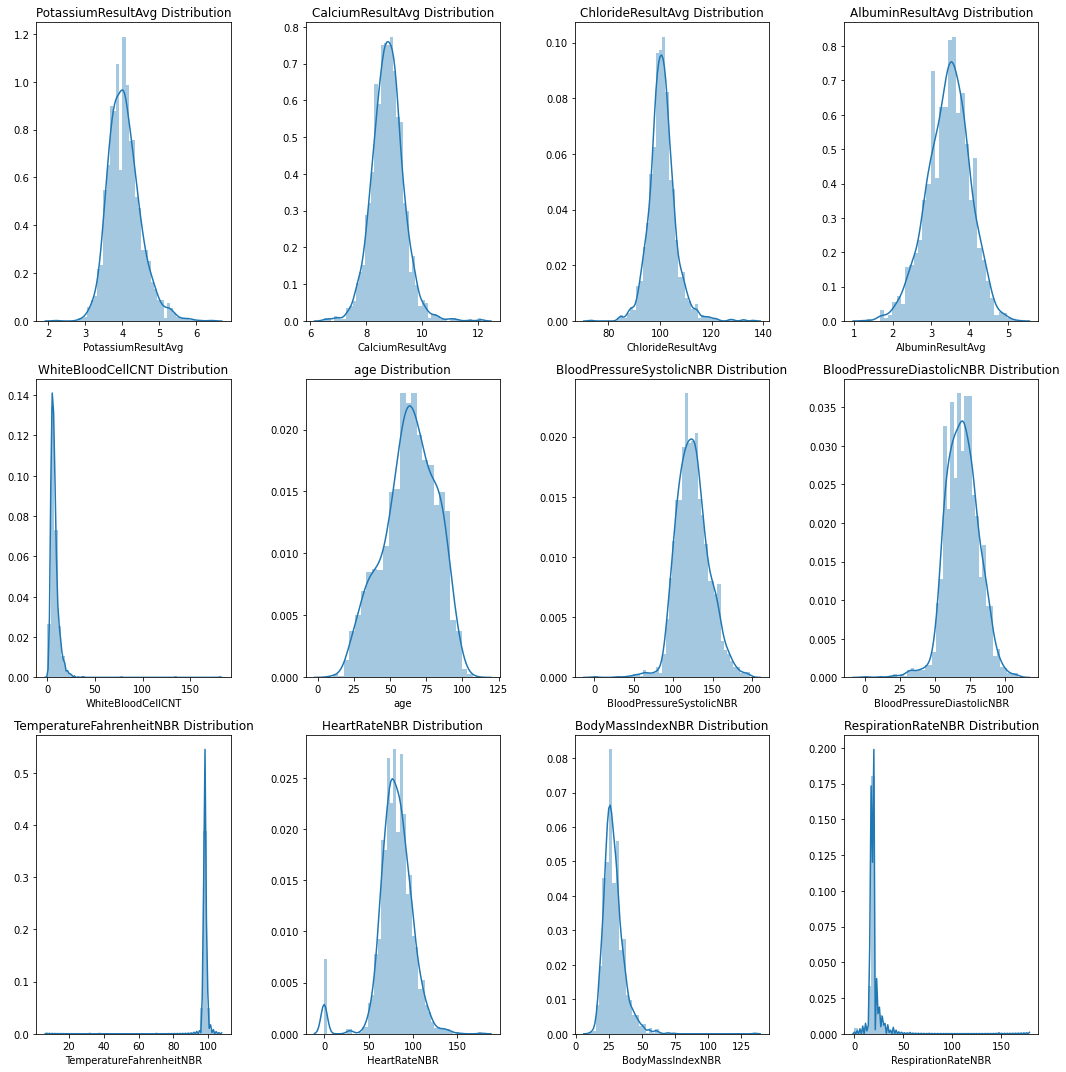

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

plot=True
if plot==True:
    fig=plt.figure(figsize=(15,15))
    for i, feature in enumerate(continus_variables.columns):
        ax=fig.add_subplot(3,4,i+1)
        sns.distplot(continus_variables[feature])
        # continus_variables[feature].hist(bins=100,ax=ax,facecolor='blue')
        ax.set_title(feature+" Distribution",color='black')
    fig.tight_layout()  
    plt.show()

In [473]:
# Look at specific relationships with SCR

## Data Validation 

In [113]:
'''
4 hospitalenounterIDs need to validate where temp is less than 90, 2 are likely celcius inputs 
'''
#final_df[final_df['TemperatureFahrenheitNBR']<90]
# hospital encounterids need to validate
#final_df[final_df['TemperatureFahrenheitNBR']>=90]['TemperatureFahrenheitNBR'].hist()
list(final_df[final_df['TemperatureFahrenheitNBR']<90].index)


[3301592925, 3302380629, 3303523236, 3305280857]

In [114]:
'''
3 hospitalenounterIDs need to validate where BMI is greater than 70
'''
final_df[final_df['BodyMassIndexNBR']>70]
# hospital encounterids need to validate
#final_df[final_df['BodyMassIndexNBR']<=70]['BodyMassIndexNBR'].hist()
list(final_df[final_df['BodyMassIndexNBR']>=70].index)

[3305534146, 3307888378, 3308879222]

In [ ]:
# Exporting final df to csv 
if export_data==True:
    final_df.to_csv(working_path.replace('/code','') + '/data/final_df.csv')

#  Model Building


Outline of plan: 

* Outcome Variable "AKI_status", a 0,1 variable
* Splitting data into Training (75%) and Test set (25%)
* Using stepwise selection (forward and backward) with pvalue threshold_in=0.01 and pvalue threshold_out = 0.05 
 

Note: Models are currently being fit with not addressing outliers in BMI or body temperature, removed Bicarbonate variable because contains many NAs  

maybe: include all two way interactions? 


In [115]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn import metrics, ensemble, tree
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RandomizedSearchCV
import statsmodels.api as sm

In [116]:
# Potentially consider all two way interactions with sex (need to discuss plan here)
# for col in final_df.columns:
#    new_col=(final_df[col]*final_df['sex'])
#    col_name="sex_" +col 
#    final_df[col_name]=new_col

In [118]:
outcomeMeasure='AKI_status'
y=final_df[outcomeMeasure]
X=final_df.drop(['AKI_status'],axis=1)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Stepwise Logistic Regression 

In [ ]:
# use cross validation first to determine optimal number of variables for inclusion?? 

In [120]:
np.seterr(divide='ignore', invalid='ignore')
model_lr = LogisticRegression(max_iter=500, random_state=42)

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    #print(X.columns)
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        #print(excluded)
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        #print(list(new_pval))
        best_pval = new_pval.min()
        #print('best_pval' & best_pval)

        if best_pval < threshold_in:
            best_feature = excluded[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = included[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X_train, y_train)

print('resulting features:')
print(result)


Add  AlbuminResultAvg               with p-value 6.99856e-19
Add  PotassiumResultAvg             with p-value 8.89857e-11
Add  CalciumResultAvg               with p-value 2.07307e-09
Add  Hypertension                   with p-value 4.15338e-07
Add  ICU                            with p-value 8.91922e-05
Add  WhiteBloodCellCNT              with p-value 0.000868334
Add  ChlorideResultAvg              with p-value 0.00246264
Add  White (non-hispanic)           with p-value 0.00604993
Add  age                            with p-value 0.00535543
Add  sex                            with p-value 0.00591309
Add  BloodPressureDiastolicNBR      with p-value 0.00654493
Add  BloodPressureSystolicNBR       with p-value 0.000946218
Drop age                            with p-value 0.0608624
resulting features:
['AlbuminResultAvg', 'PotassiumResultAvg', 'CalciumResultAvg', 'Hypertension', 'ICU', 'WhiteBloodCellCNT', 'ChlorideResultAvg', 'White (non-hispanic)', 'sex', 'BloodPressureDiastolicNBR', 'Blood

In [121]:
print(result)

['AlbuminResultAvg', 'PotassiumResultAvg', 'CalciumResultAvg', 'Hypertension', 'ICU', 'WhiteBloodCellCNT', 'ChlorideResultAvg', 'White (non-hispanic)', 'sex', 'BloodPressureDiastolicNBR', 'BloodPressureSystolicNBR']


In [122]:
training_inputs_lr = X_train
training_inputs_lr['Yintercept']=1

testing_inputs_lr = X_test
testing_inputs_lr['Yintercept']=1

model_lr.fit(training_inputs_lr[result], y_train)
Y_pred = model_lr.predict(testing_inputs_lr[result])

acc_log = round(model_lr.score(training_inputs_lr[result], y_train) * 100, 2)
acc_log

71.22

# Decision Tree 

In [123]:
# Decision Tree
training_inputs_dt = X_train
testing_inputs_dt = X_test

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs_dt, y_train)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs_dt, y_test)

0.6287425149700598

# Random forest

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
import numpy as np

In [125]:
random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy']}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           scoring='roc_auc', 
                           cv=cross_validation)

training_inputs_rf = X_train
testing_inputs_rf = X_test

grid_search.fit(training_inputs_rf, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.7378208118194085
Best parameters: {'criterion': 'entropy', 'n_estimators': 100}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [126]:
# Build a classification task using 3 informative features
# Use all inputs (rather than just X_Train)
all_inputs = X

X_cl, y_cl = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

importances = grid_search.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in grid_search.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_cl.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, all_inputs.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature CalciumResultAvg (0.099015)
2. feature age (0.094231)
3. feature PotassiumResultAvg (0.089605)
4. feature WhiteBloodCellCNT (0.089177)
5. feature ChlorideResultAvg (0.085905)
6. feature AlbuminResultAvg (0.085427)
7. feature HeartRateNBR (0.073295)
8. feature BloodPressureSystolicNBR (0.067341)
9. feature BloodPressureDiastolicNBR (0.064691)
10. feature TemperatureFahrenheitNBR (0.063407)


# Neural Network

In [127]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.losses import logcosh, binary_crossentropy
from tensorflow.keras.activations import relu, elu, sigmoid
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import roc_curve
 

In [159]:
X_train.shape[1]

24

In [160]:
model = Sequential()
model.add(Dense(220,input_shape=(X_train.shape[1],)))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(20))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', ])

class_weight = {1: 0.5, 0: 0.5}

In [148]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 220)               5500      
_________________________________________________________________
activation_6 (Activation)    (None, 220)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                4420      
_________________________________________________________________
activation_7 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 9,941
Trainable params: 9,941
Non-trainable params: 0
____________________________________________________

In [131]:
print(len(model.layers))

6


In [161]:
scl = StandardScaler()
scl.fit(X_train)
X_train_t = scl.transform(X_train)
X_test_t = scl.transform(X_test)
#model._estimator_type="regressor"   # for predictive plots but this changes accuracy of models

In [162]:
model.fit(X_train_t, y_train ,batch_size=500,epochs=25,validation_split=0.2, class_weight=class_weight)

Train on 1200 samples, validate on 301 samples
Epoch 1/25
1200/1200 [==============================] - 1s 497us/sample - loss: 0.3861 - acc: 0.3792 - val_loss: 0.3552 - val_acc: 0.4684
Epoch 2/25
1200/1200 [==============================] - 0s 21us/sample - loss: 0.3443 - acc: 0.5292 - val_loss: 0.3232 - val_acc: 0.6811
Epoch 3/25
1200/1200 [==============================] - 0s 34us/sample - loss: 0.3274 - acc: 0.6583 - val_loss: 0.3066 - val_acc: 0.7143
Epoch 4/25
1200/1200 [==============================] - 0s 16us/sample - loss: 0.3199 - acc: 0.6583 - val_loss: 0.2967 - val_acc: 0.7176
Epoch 5/25
1200/1200 [==============================] - 0s 31us/sample - loss: 0.3132 - acc: 0.6692 - val_loss: 0.2891 - val_acc: 0.7143
Epoch 6/25
1200/1200 [==============================] - 0s 22us/sample - loss: 0.3060 - acc: 0.6792 - val_loss: 0.2830 - val_acc: 0.7276
Epoch 7/25
1200/1200 [==============================] - 0s 22us/sample - loss: 0.2987 - acc: 0.6925 - val_loss: 0.2783 - val_acc: 

# Model Evaluation 

In [163]:
def fncThreshold(v):
    if (v <  200):
        return 0
    else:
        return 1

def get_measures(y_true, y_pred, th=0.5):
    yhat_classes = np.where(y_pred > th, 1, 0)
    acc = metrics.accuracy_score(y_true, yhat_classes)
    bal_acc = metrics.balanced_accuracy_score(y_true, yhat_classes)
    
    sen = metrics.recall_score(y_true, yhat_classes)
    auc = metrics.roc_auc_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, yhat_classes)
    f1 = metrics.f1_score(y_true, yhat_classes)

    
    return [acc, bal_acc, sen, auc, prec, f1]

dataset = 'test'
overall_peformance_df = pd.DataFrame(columns=['model', 'dataset', 'Outcome Measure', 'accuracy', 'balanced accuracy', 'sensitivity', 'AUROC', 'AUPRC', 'F1'])

if dataset == 'train':
    dat = y_train
   # dat_nn_lin = y_train_nn
    y_nn = model.predict_proba(X_train_t)
    # y_nn_lin = NN_model.predict_proba(X_train_nn)
    y_rf = grid_search.predict_proba(X_train)[:, 1]
    y_lr = model_lr.predict_proba(X_train[result])[:, 1] # Use result which is list of predictors to only keep variables in model
    y_DT=decision_tree_classifier.predict_proba(X_train)[:, 1]

elif dataset == 'test':
    dat = y_test
    #dat_nn_lin = y_test_nn.copy()

    # dat_nn_lin.loc[dat_nn_lin['MME_0to24h_postop'] < 90, 'MME_0to24h_postop'] = 0
    # dat_nn_lin.loc[dat_nn_lin['MME_0to24h_postop'] >= 90, 'MME_0to24h_postop'] = 1
    # dat_nn_lin['MME_0to24h_postop']=dat_nn_lin['MME_0to24h_postop'].astype('int').astype('category')

    y_nn = model.predict_proba(X_test_t)

    #y_nn_lin = NN_model.predict_proba(X_test_nn)
    #y_nn_lin = np.vectorize(fncThreshold)(NN_model.predict(X_test_nn)).flatten()

    y_rf = grid_search.predict_proba(X_test)[:, 1]
    y_lr = model_lr.predict_proba(X_test[result])[:, 1]
   
    #y_Fullr = Full_logisticRegr.predict_proba(X_test)[:, 1]
    y_DT=decision_tree_classifier.predict_proba(X_test)[:, 1]
    
overall_peformance_df.loc[len(overall_peformance_df)] = ['Logistic Regression', dataset, outcomeMeasure] + get_measures(dat, y_lr)

# # Full Logistic Regresion
#overall_peformance_df.loc[len(overall_peformance_df)] = ['Full Logistic Regression', dataset, outcomeMeasure] + get_measures(dat, y_Fullr)

overall_peformance_df.loc[len(overall_peformance_df)] = ['Random Forest', dataset, outcomeMeasure] + get_measures(dat, y_rf)

# Decision Tree
overall_peformance_df.loc[len(overall_peformance_df)] = ['Decision Tree', dataset, outcomeMeasure] + get_measures(dat, y_DT)

overall_peformance_df.loc[len(overall_peformance_df)] = ['Neural network', dataset, outcomeMeasure] + get_measures(dat, y_nn)

#overall_peformance_df.loc[len(overall_peformance_df)] = ['Neural network - linear', dataset, outcomeMeasure_nn] + get_measures(dat_nn_lin, y_nn_lin)

overall_peformance_df

,model,dataset,Outcome Measure,accuracy,balanced accuracy,sensitivity,AUROC,AUPRC,F1
0,Logistic Regression,test,AKI_status,0.694611,0.630922,0.379679,0.752103,0.657407,0.481356
1,Random Forest,test,AKI_status,0.720559,0.654867,0.395722,0.782545,0.732673,0.513889
2,Decision Tree,test,AKI_status,0.628743,0.603248,0.502674,0.603248,0.502674,0.502674
3,Neural network,test,AKI_status,0.714571,0.658742,0.438503,0.764365,0.683333,0.534202


# Predictive Plots

## AUC 

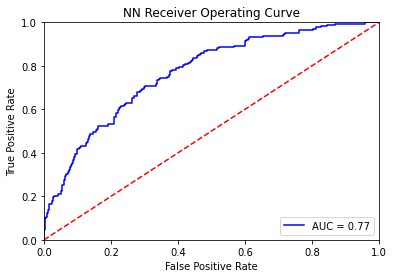

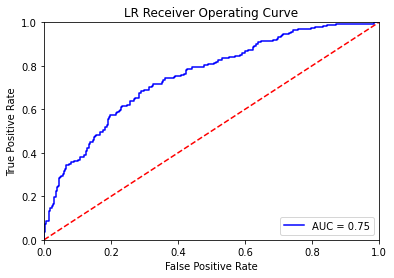

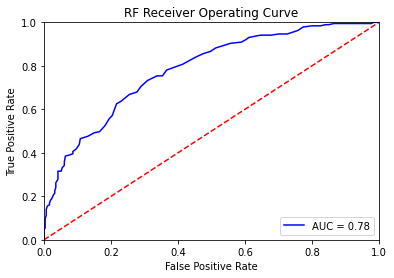

In [137]:
# Neural Network
dat = y_test
y_nn = model.predict_proba(X_test_t)
fpr, tpr, thresholds = roc_curve(dat, y_nn)
#roc_auc_score(dat, y_nn)
roc_auc = metrics.auc(fpr, tpr)
plt.title('NN Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# LR 
dat = y_test
lr_probs = model_lr.predict_proba(X_test[result])[:, 1]
#lr_preds=y_lr_pred[:, 1]
fpr, tpr, thresholds = roc_curve(dat, lr_probs)
#roc_auc_score(dat, lr_probs)
roc_auc = metrics.auc(fpr, tpr)
plt.title('LR Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# RF
dat = y_test
rf_probs= grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(dat, rf_probs)
roc_auc = metrics.auc(fpr, tpr)
plt.title('RF Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Effect Plots 

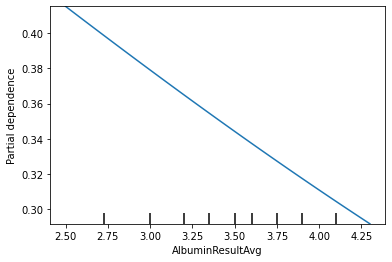

In [139]:
 # partial dependence plots 
from sklearn.inspection import plot_partial_dependence
X=X_train[['AlbuminResultAvg', 'PotassiumResultAvg', 'CalciumResultAvg', 'Hypertension', 'ICU', 'WhiteBloodCellCNT', 'ChlorideResultAvg', 'White (non-hispanic)', 'sex','BloodPressureDiastolicNBR', 'BloodPressureSystolicNBR']]
plot_partial_dependence(model_lr, X, features = [0],n_cols=1) 
fig = plt.gcf()
#fig.suptitle('Logistic Regression Effect plots')
fig.subplots_adjust(hspace=1,wspace=2)

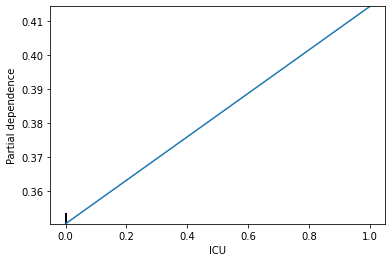

In [140]:
# Random Forest Effect Plots 
plot_partial_dependence(grid_search, X_train, features = [18],n_cols=1) 

In [164]:
#plot_partial_dependence(estimator=model, X=X_train_t, features = [18],n_cols=1,feature_names=X_train.columns[0:19]) # model._estimator_type="regressor" (need to fit this)
# Neural Network Effect Plots 
#plot_partial_dependence(model, X_train_t, features = [0,1,2],n_cols=3,feature_names=X_train.columns[0:3]) 